In [2]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

imgL = cv2.imread('~/Homework02_dataset/Task03/left/000001.png', 0)
imgR = cv2.imread('~/Homework02_dataset/Task03/right/000001.png', 0)
sift = cv2.SIFT()

# Initiating SIFT detector
sift = cv2.SIFT_create()

# finding the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(imgL, None)
kp2, des2 = sift.detectAndCompute(imgR, None)


# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k = 2)

good = []
ptsL = []
ptsR = []

# ratio test as per Lowe's paper
for i, (m, n) in enumerate(matches):
    if m.distance < 0.8 * n.distance:
        good.append(m)
        ptsL.append(kp1[m.queryIdx].pt)
        ptsR.append(kp2[m.trainIdx].pt)

ptsL = np.int32(ptsL)
ptsR = np.int32(ptsR)

F, mask = cv2.findFundamentalMat(ptsL, ptsR, cv2.RANSAC)
# We select only inlier points
ptsL = ptsL[mask.ravel() == 1]
ptsR = ptsR[mask.ravel() == 1]

In [3]:
def drawlines(img1, img2, lines, pts1, pts2):
    '''
    img1 - image on which we draw the epilines
    for the points in img2 lines - corresponding 
    epilines.
    '''
    r, c = img1.shape
    imgL = cv2.cvtColor(imgL, cv2.COLOR_GRAY2BGR)
    imgR = cv2.cvtColor(imgR, cv2. COLOR_GRAY2BGR)
    for r, ptL, ptR in zip(lines, ptsL, ptsR):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1] ])
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1] ])
        imgL = cv2.line(imgL, (x0, y0), (x1, y1), color, 1)
        imgL = cv2.circle(imgL, tuple(pt1), 5, color, -1)
        imgR = cv2.circle(imgR, tuple(pt2), 5, color, -1)
    return imgL, imgR

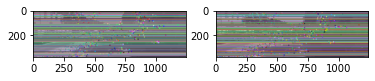

In [3]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
linesL = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F)
linesL = linesL.reshape(-1, 3)
imgL1, imgL2 = drawlines(imgL, imgR, linesL, ptsL, ptsR)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
linesR = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
linesR = linesR.reshape(-1, 3)
imgR1, imgR2 = drawlines(imgR, imgL, linesR, ptsR, ptsL)

plt.subplot(121), plt.imshow(imgL1)
plt.subplot(122), plt.imshow(imgR1)
plt.show()

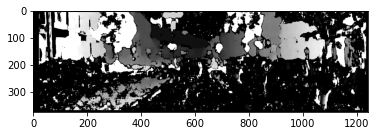

In [4]:
# disparity map
stereo = cv2.StereoBM_create(numDisparities = 16, blockSize = 15)
disparity = stereo.compute(imgL, imgR)
plt.imshow(disparity, 'gray')
plt.show()